# Visualizing the results in images

Notebook for a visual analysis of the results. It makes the images for the papers comparing the different frameworks

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
import matplotlib.gridspec as gridspec
import json

# make all images 800 dpi
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# setup figsize
plt.rcParams['figure.figsize'] = (20, 9)
# setup title 
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.titleweight'] = 'bold'

# setup xlabel and ylabel in axes
plt.rcParams['axes.labelsize'] = 25

# setup ticks size
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

# setup legend size
plt.rcParams['legend.fontsize'] = 18
sns.set_style('whitegrid')

In [2]:
datasets = list(sorted(['adult', 'Australian', 'cnae-9', 'credit-g', 'mfeat-factors', 'bank-marketing', 'Amazon_employee_access']))

In [3]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tpot.export_utils import set_param_recursive

In [4]:
save_path = os.path.join('..', 'images')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [5]:
def format_thousands(x, pos):
    return f'{int(x/1000)}k'

In [6]:
source_path = os.path.join('..', 'data', 'results-csv')

# Boxplots

In [7]:
frameworks = {
    'edca-1-0-0' : 'EDCA',
    'flaml' : 'FLAML',
    'tpot' : 'TPOT',
}

In [36]:
def plot_boxplot(variable, ylabel, ylim=(0, 1), train_data=''):
    col = 0
    row = 0
    fig, axes = plt.subplots(nrows=2, ncols=int((len(datasets)+1)/2), sharey=True, figsize=(20,9))
    if train_data:
        train_data = train_data + '_'
    for dataset in datasets:
        plot_data = pd.DataFrame()

        ax = axes[row][col]
    
        for framework in list(frameworks.keys()):
            framework_name = framework
            try:
                if variable == 'total_evaluated' and framework == 'flaml':
                    var = 'num_iterations'
                elif variable == 'total_evaluated' and 'edca' in framework:
                    var = 'num_pipelines_tested'
                    framework_name = 'evo'

                elif 'edca' in framework:
                    framework_name = 'evo'
                    var = variable

                else:
                    var = variable

                if 'tpot' in framework:
                    framework_name = 'tpot'

                aux = train_data
                if framework == 'tpot':
                    aux = ''
                df = pd.read_csv(os.path.join(source_path, dataset, f'{framework}-results.csv'))
                plot_data = pd.concat([plot_data, pd.DataFrame({'Framework' : framework, 'value' : df[f'{framework_name}_{aux}{var}']})])
            except Exception as e:
                plot_data = pd.concat([plot_data, pd.DataFrame({'Framework' : [framework], 'value' : None})])
        plot_data.Framework = plot_data.Framework.map(frameworks)
        sns.boxplot( y = "Framework", x = "value", data = plot_data, width=0.75, dodge=True, orient="h", ax = ax)
        # ax.get_legend().set_visible(False)
        ax.set_xlabel('')
        if dataset in ['credit-g', 'Amazon_employee_access'] and variable in ['mcc'] :
            ax.set_xlim((0, 0.5))
        elif dataset == 'bank-marketing' and variable in ['mcc']:
            ax.set_xlim((0.25, 0.75))
        elif dataset != 'credit-g' and variable in ['mcc']:
            ax.set_xlim((0.5, 1))
        if variable == 'f1':
            ax.set_xlim((0.6, 1))
        if variable in ['data_%', 'features_%', 'sample_%'] and ylim:
            ax.set_xlim(ylim)
        if plot_data.value.mean() > 1000:
            ax.xaxis.set_major_formatter(plt.FuncFormatter(format_thousands))
        ax.tick_params(axis='both', which='both', size=25)
        # handles, labels = ax.get_legend_handles_labels()
        ax.set_xlabel(ylabel, fontdict={'size': 28})
        if col == 0:
            ax.set_ylabel('Frameworks', fontdict={'size': 28})
        else:ax.set_ylabel('')
        if dataset == 'Amazon_employee_access':
            ax.set_title('Amazon')
        elif dataset == 'bank-marketing':
            ax.set_title('bank')
        else:
            ax.set_title(dataset)
        col += 1
        if col == int((len(datasets)+1)/2):
            row += 1
            col = 0
    # fig.legend(handles, labels, loc='lower center', ncol=3)
    plt.tight_layout()
    fig.delaxes(axes[-1][-1])
    plt.subplots_adjust(wspace=0.05)
    plt.savefig(os.path.join(save_path, f'boxplot_{train_data + variable.strip("_%")}_{list(frameworks.keys())}.png'), bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f'boxplot_{train_data + variable.strip("_%")}_{list(frameworks.keys())}.eps'), bbox_inches='tight', format='eps')
    # plt.savefig(os.path.join(save_path, f'boxplot_{variable.strip("_%")}.pdf'), bbox_inches='tight')
    plt.show()

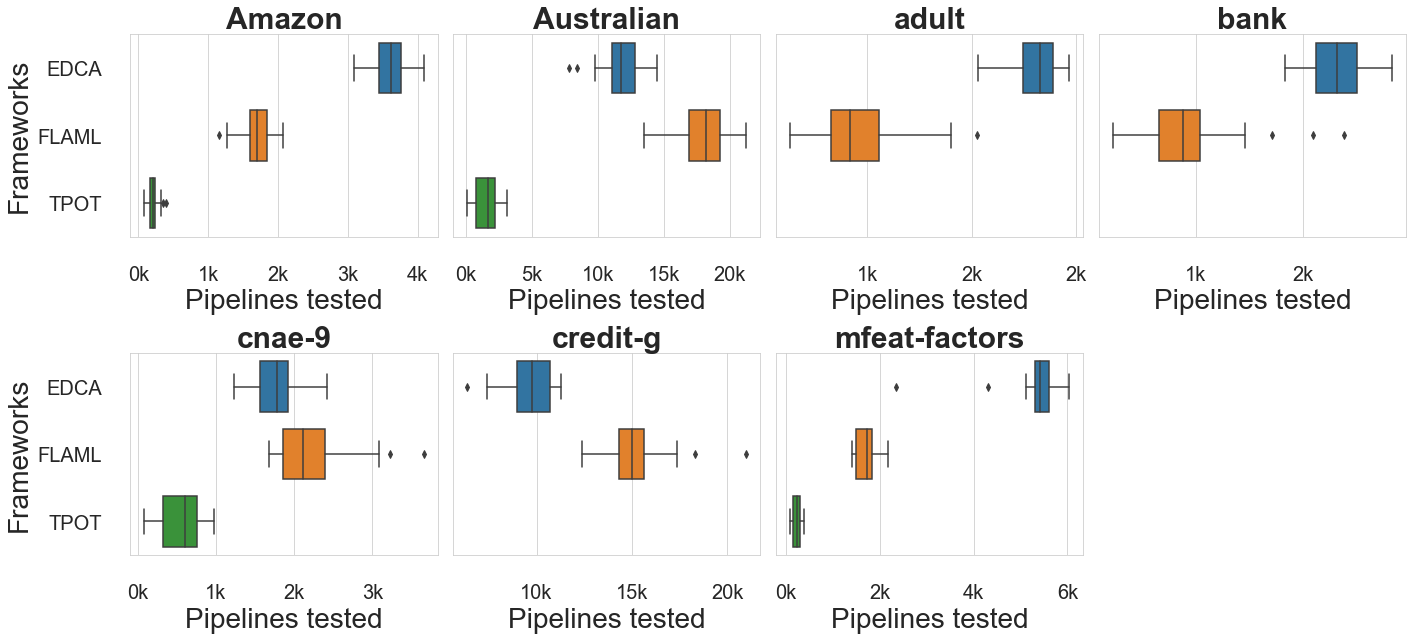

In [37]:
plot_boxplot('total_evaluated', ylabel='Pipelines tested', ylim=None)

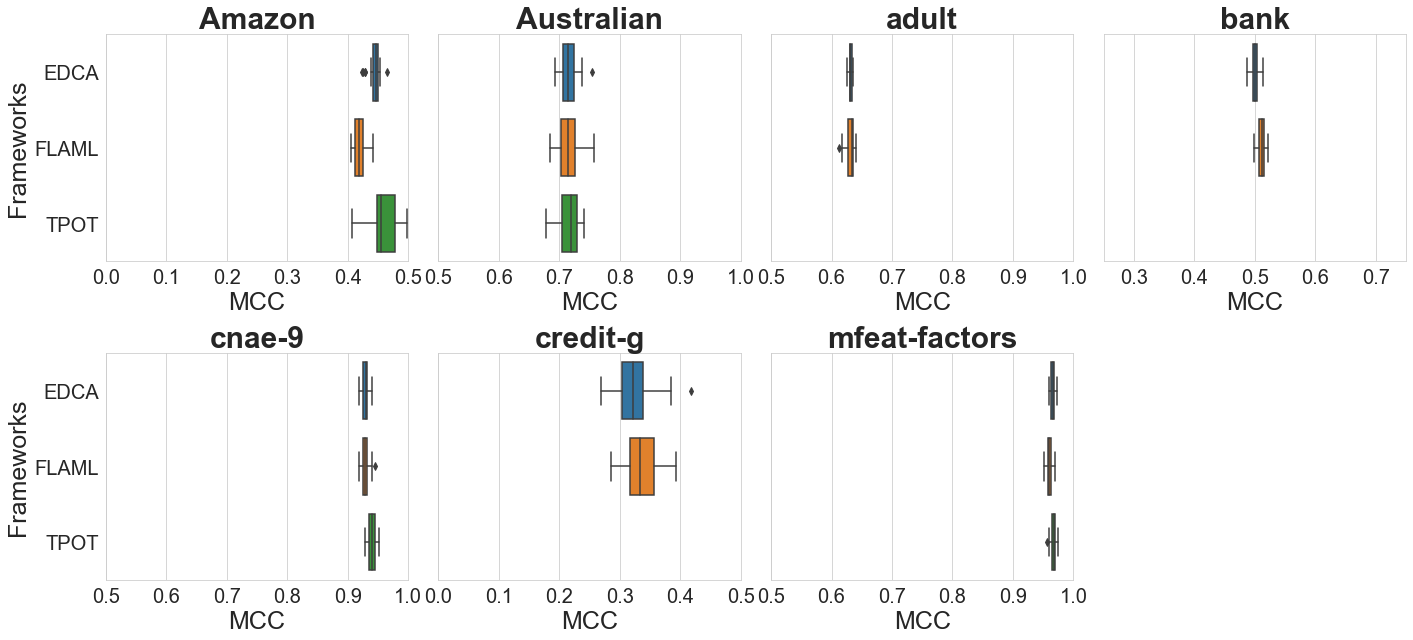

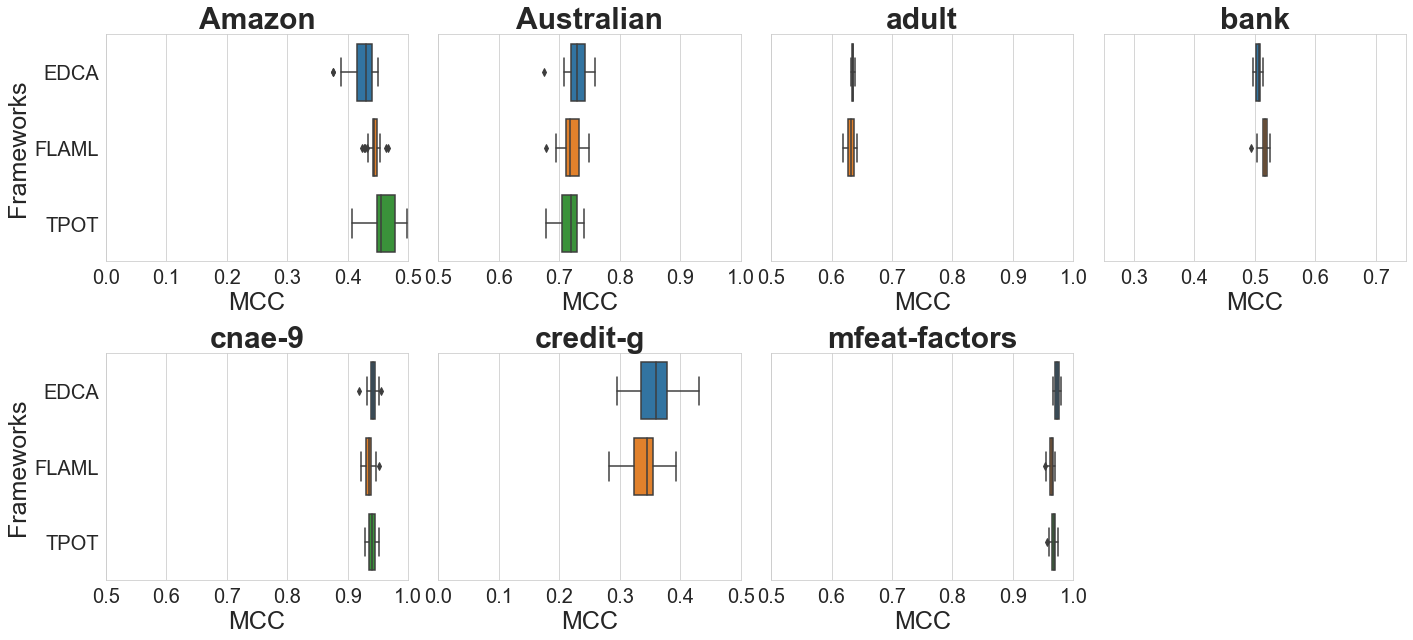

In [12]:
plot_boxplot('mcc', ylabel='MCC')
plot_boxplot('mcc', ylabel='MCC', train_data='all_data')

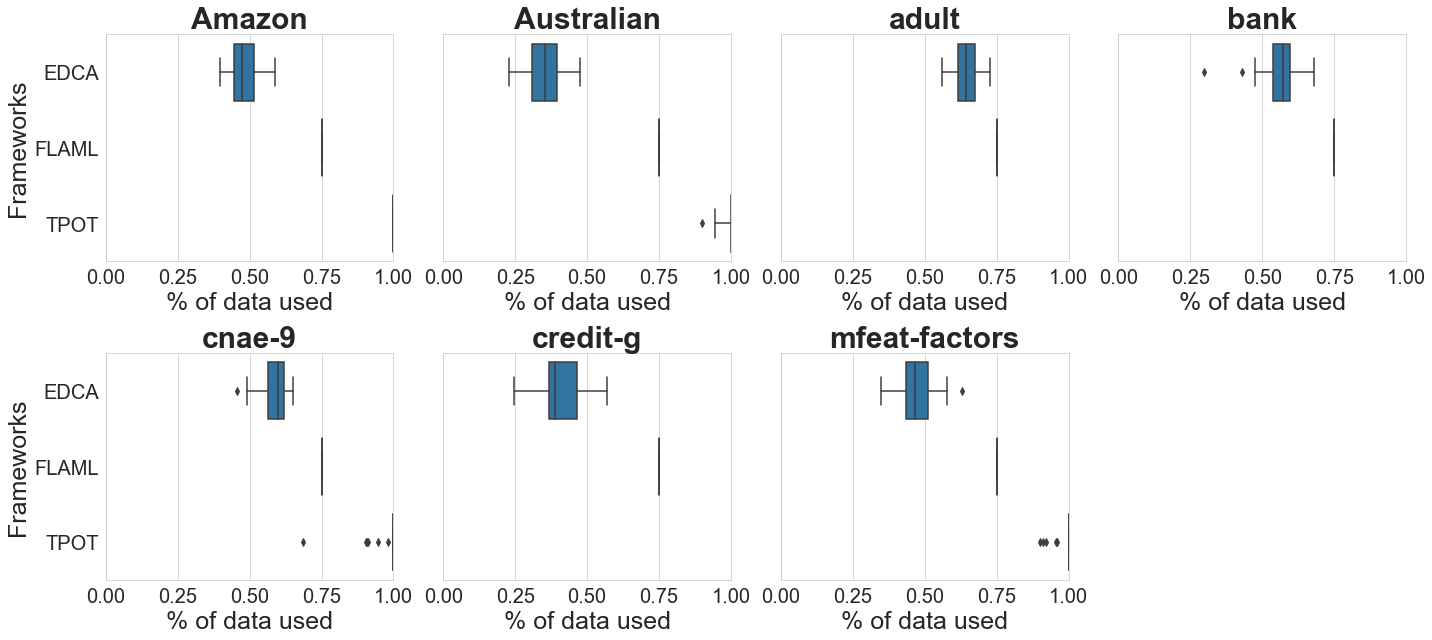

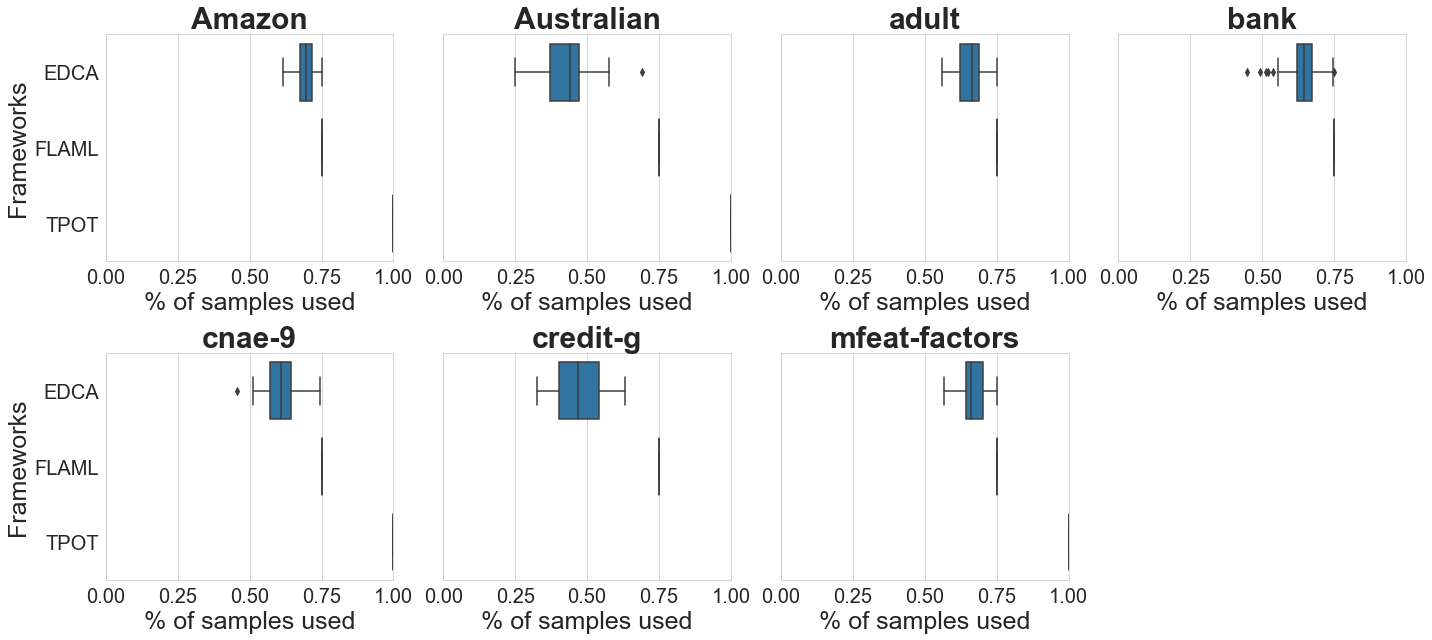

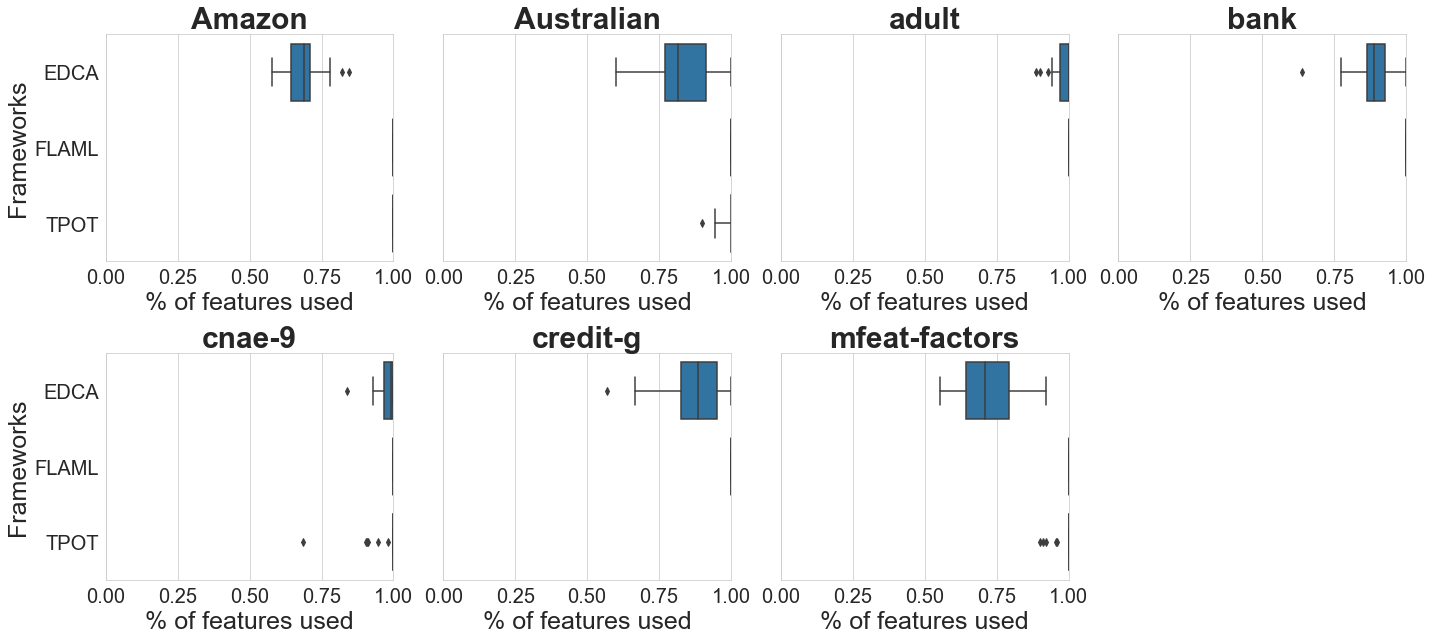

In [56]:
plot_boxplot('data_%', ylabel='% of data used')
plot_boxplot('sample_%', ylabel='% of samples used')
plot_boxplot('features_%', ylabel='% of features used')

## fitness functions

In [84]:
frameworks = {
    'edca-1-0-0' : 'EDCA-1-0-0',
}

In [85]:
values = {}
for dataset in datasets:
    values[dataset] = {framework:{} for framework in frameworks.keys()}

In [86]:
for dataset in datasets:
    for framework, label in frameworks.items():
        path = os.path.join('..', 'thesis-results', 'datasets-divided', framework, dataset)
        for exp in os.listdir(path):
            for fold in range(1, 5+1):
                try:
                    bests = pd.read_csv(os.path.join(path, exp, 'evo', f'evo_fold{fold}', 'bests.csv'))
                    for m in [m for m in bests.columns if m not in ['Iteration','config']]:
                        values[dataset][framework][m] = values[dataset][framework].get(m, []) + [list(bests[m])]
                except:
                    continue

In [87]:
def get_mean_array(array, until_min=False):
    max_generations = max(len(v) for v in array)
    min_generations = min(len(v) for v in array)
    max_exps = len(array)

    data = np.zeros(shape=(max_exps, max_generations))
    data[::] = np.nan
    for i, v in enumerate(array):
        data[i, :len(v)] = v
    
    mean = np.nanmean(data, axis=0)
    if until_min:
        mean = mean[:min_generations]
    return mean

In [88]:
def plot_evolution_along_generations(values, metric, ylabel):
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(nrows=2, ncols=int(len(datasets)/2), figsize=(20, 10), sharey=False)
    col = 0
    row = 0
    legends = {}
    for dataset in datasets:
        ax = axes[row][col]
        for framework, label in frameworks.items():
            mean = get_mean_array(values[dataset][framework][metric], until_min=True)
            l = ax.plot(mean, label=label, lw=2)
            legends[label] = l[0]
            ax.set_xlabel('Generation', fontdict=dict(size=16))
            ax.set_ylabel(ylabel, fontdict=dict(size=16))
            ax.set_title(dataset, fontdict=dict(size=20, weight='bold'))
            ax.tick_params(axis='both', which='both', labelsize=14)
            # ax.legend(loc='upper right')
        col += 1
        if col == int(len(datasets)/2):
            col = 0
            row += 1

    fig.legend(handles=list(legends.values()), labels=list(legends.keys()), loc='lower center', ncol=len(legends), fontsize=16, bbox_to_anchor=(0.5, 0))
    fig.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(save_path, f'evolution_along_generations_{metric}.png'), bbox_inches='tight')
    plt.show()

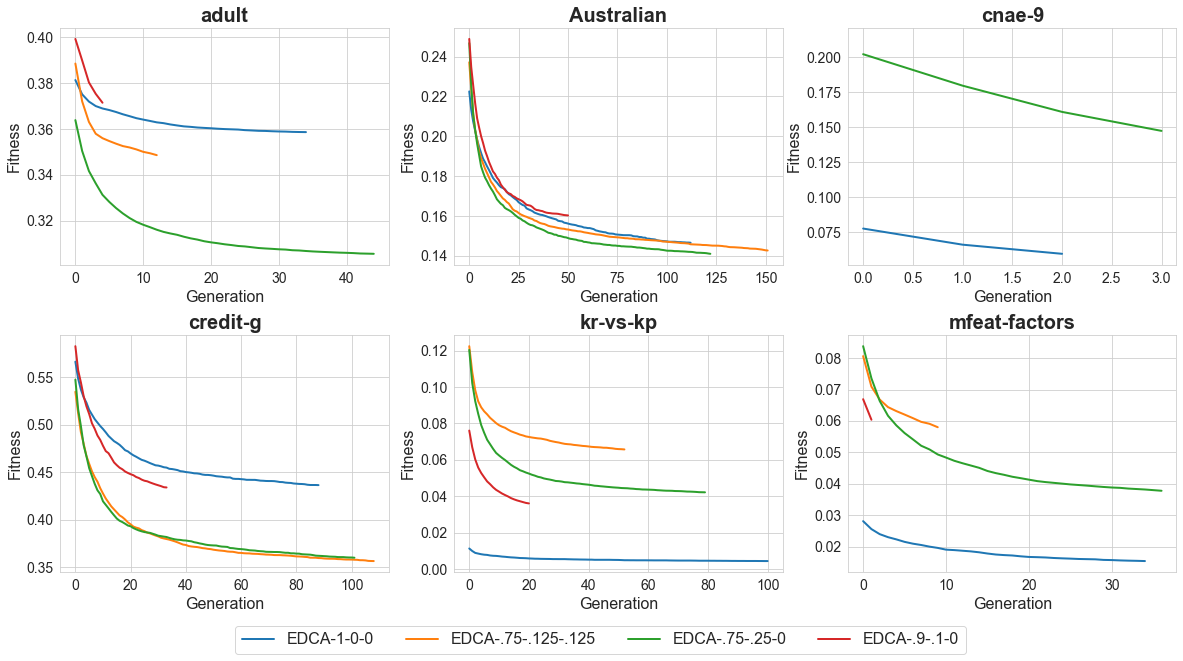

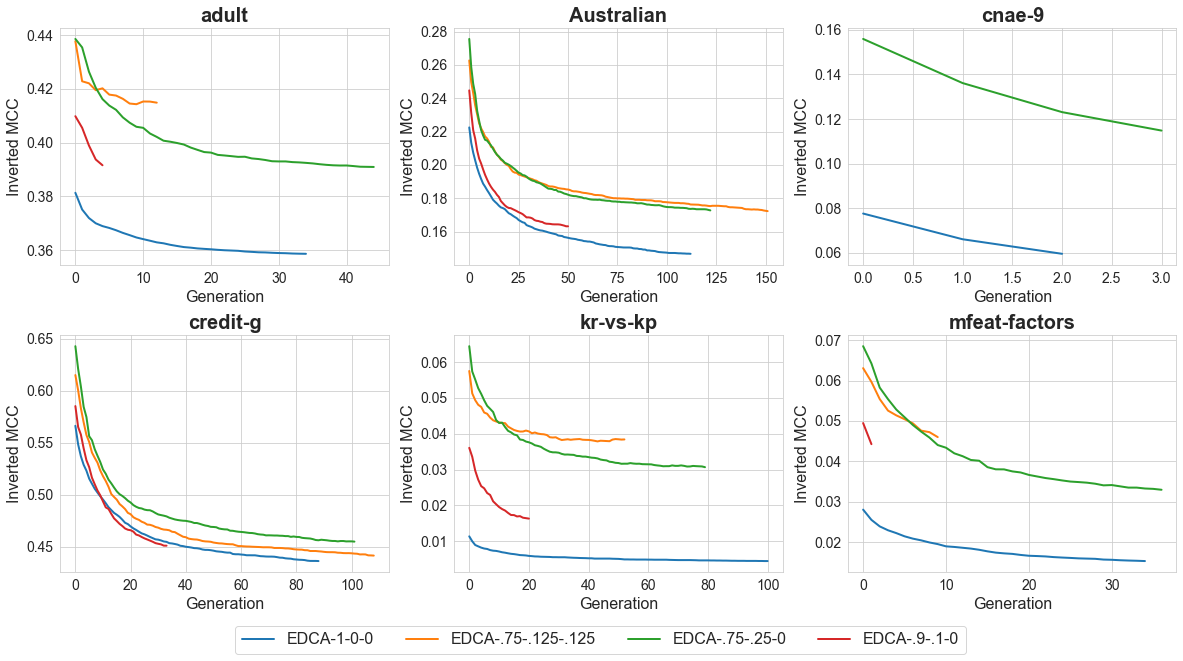

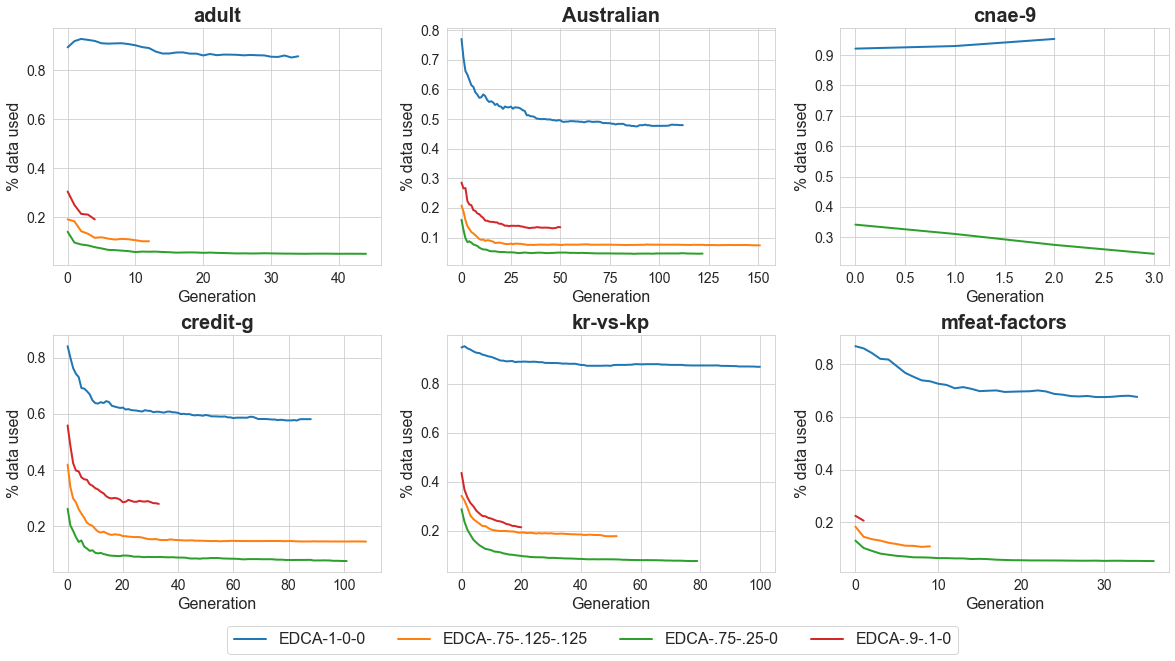

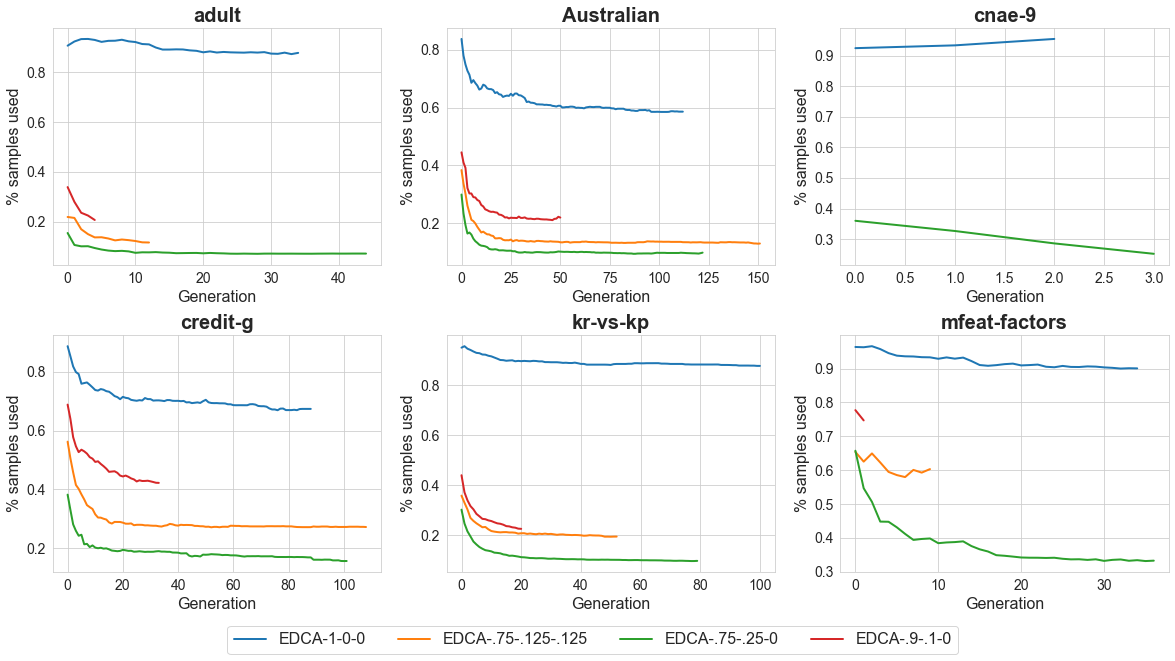

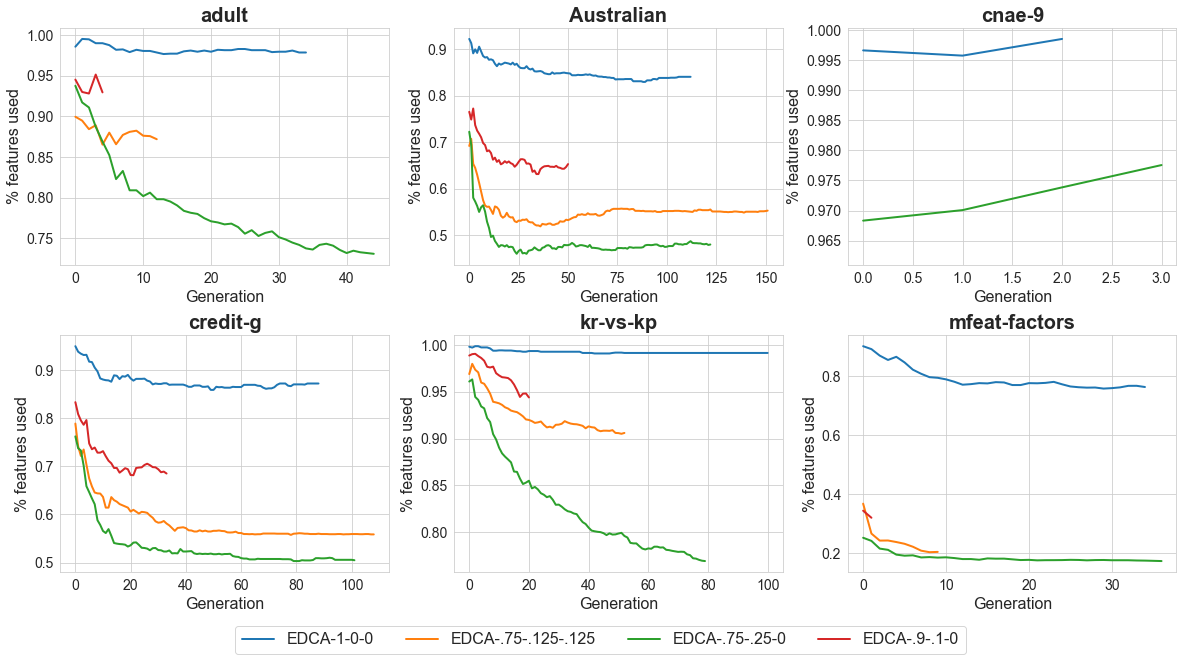

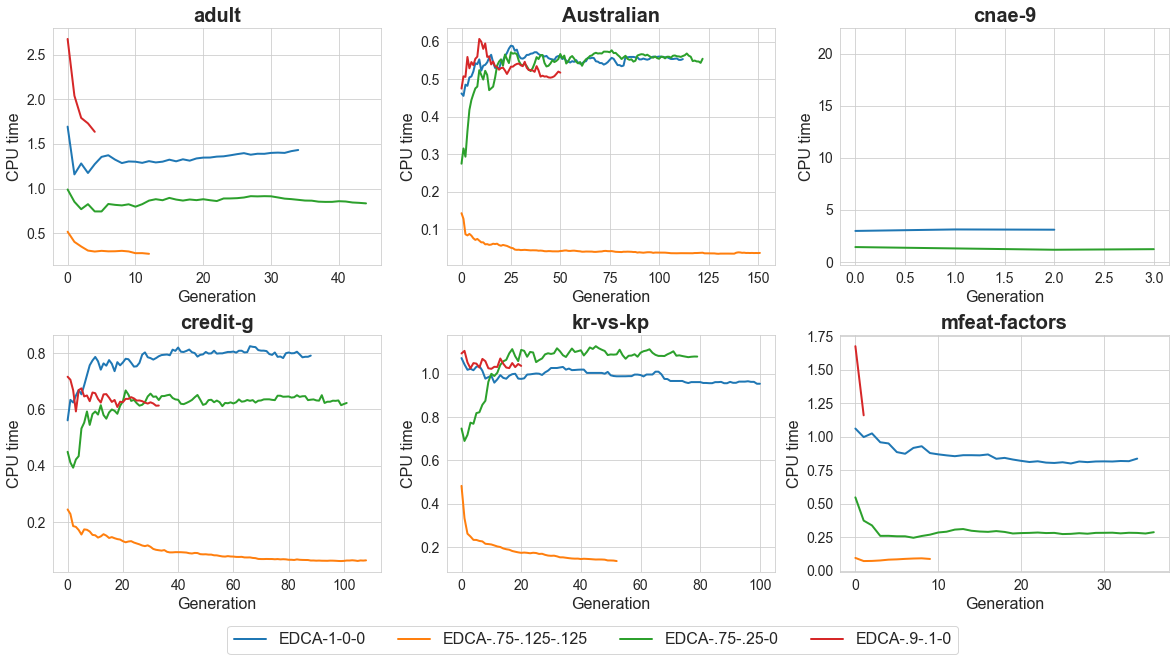

In [89]:
plot_evolution_along_generations(values, 'fitness', 'Fitness')
plot_evolution_along_generations(values, 'inv_metric', 'Inverted MCC')
plot_evolution_along_generations(values, 'train_percentage', '% data used')
plot_evolution_along_generations(values, 'sample_percentage', '% samples used')
plot_evolution_along_generations(values, 'feature_percentage', '% features used')
plot_evolution_along_generations(values, 'cpu_time', 'CPU time')

In [90]:
def plot_evolution_along_generations_metrics(values, metrics, framework):
    fig, axes = plt.subplots(nrows=2, ncols=int(len(datasets)/2), figsize=(20, 10), sharey=False)
    sns.set_style('whitegrid')
    col = 0
    row = 0
    legends = {}

    for dataset in datasets:
        ax = axes[row][col]
        for metric, label in metrics.items():
            array = values[dataset][framework][metric]
            mean = get_mean_array(array, until_min=True)
            l = ax.plot(mean, label=label)
            legends[label] = l[0]
            ax.set_xlabel('Generation', fontdict=dict(size=16))
            ax.set_ylabel("Component's Value", fontdict=dict(size=16))
            ax.set_title(dataset, fontdict=dict(size=20, weight='bold'))
            ax.tick_params(axis='both', which='both', labelsize=14)
            # ax.legend(loc='upper right')

        col += 1
        if col == int(len(datasets)/2):
            col = 0
            row += 1
    fig.legend(handles=list(legends.values()), labels=list(legends.keys()), loc='lower center', ncol=len(legends), fontsize=16, bbox_to_anchor=(0.5, 0))
    fig.subplots_adjust(hspace=0.3)
    plt.savefig(os.path.join(save_path, f'evolution_along_generations_{framework}_{list(metrics.keys())}.png'), bbox_inches='tight')
    plt.show()

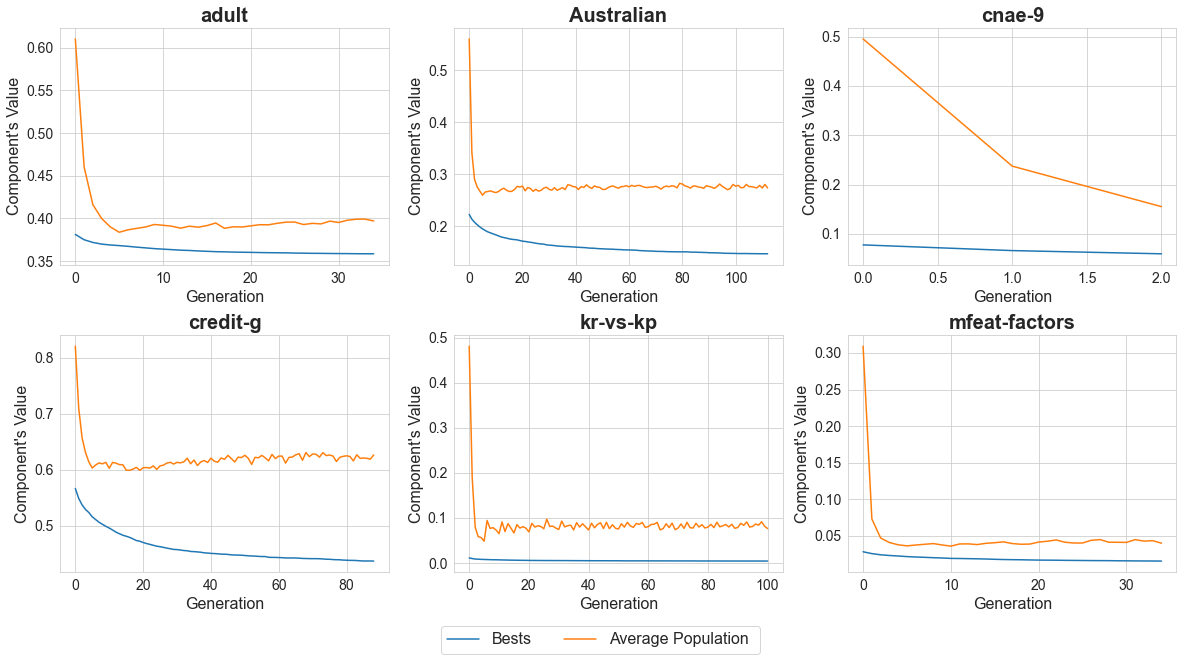

In [91]:
plot_evolution_along_generations_metrics(
    values=values,
    framework='edca-1-0-0',
    metrics = {
        'fitness' : 'Bests',
        'average' : 'Average Population ',
    }
)

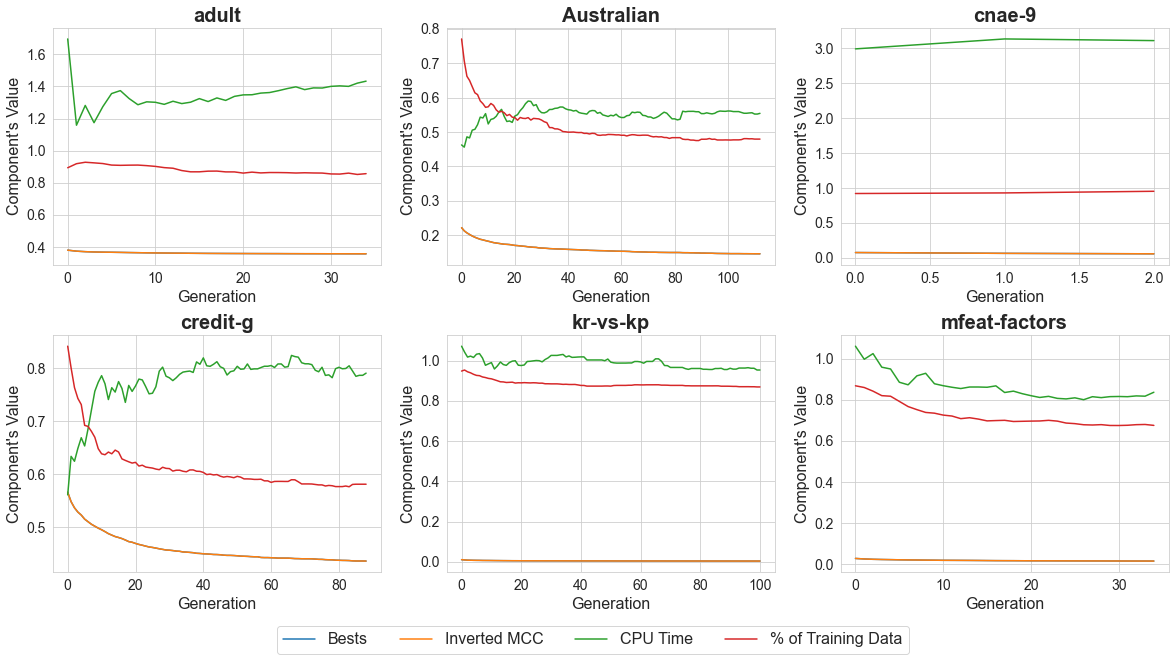

In [92]:
plot_evolution_along_generations_metrics(
    values=values,
    framework='edca-1-0-0',
    metrics = {
        'fitness' : 'Bests',
        'inv_metric' : 'Inverted MCC',
        'cpu_time' : 'CPU Time',
        'train_percentage' : '% of Training Data'
    }
)

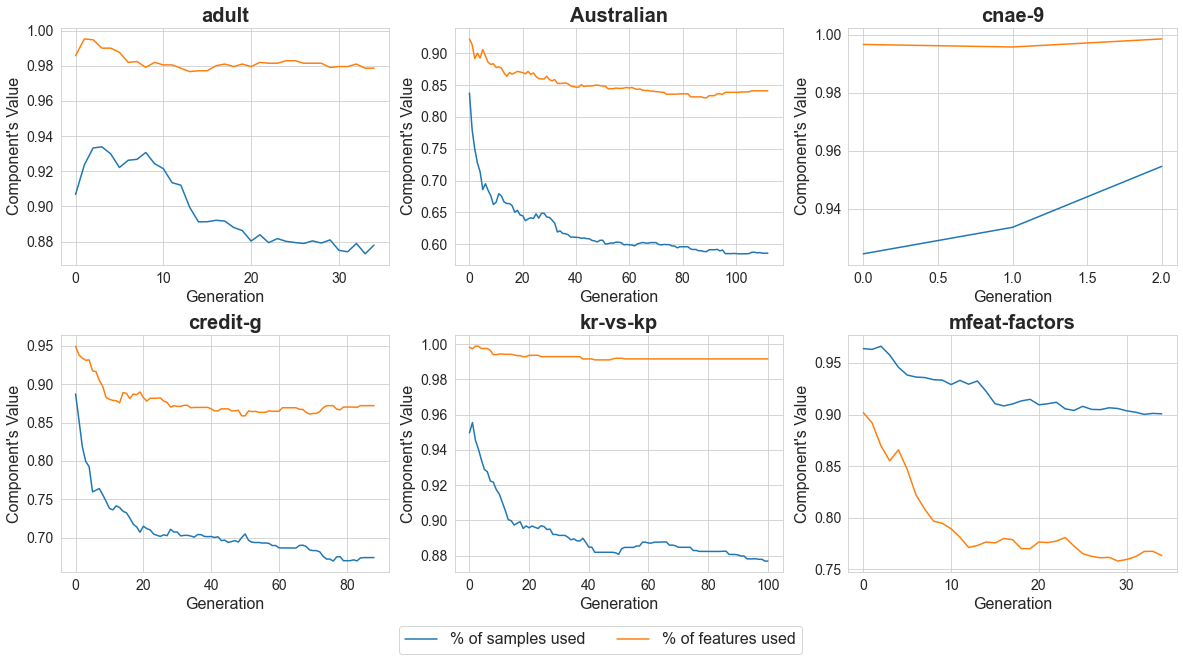

In [93]:
plot_evolution_along_generations_metrics(
    values=values,
    framework='edca-1-0-0',
    metrics = {
        'sample_percentage' : '% of samples used',
        'feature_percentage' : '% of features used'
    }
)

In [94]:
for dataset in datasets:
    for framework in frameworks:
        print(dataset, framework)
        cpu_time = get_mean_array(values[dataset][framework]['cpu_time'])
        inv_metric = get_mean_array(values[dataset][framework]['inv_metric'])
        print(np.corrcoef(cpu_time, inv_metric)[0, 1])

adult edca-1-0-0
0.24037890234963633
adult edca-75-125-125
0.6342654444529064
adult edca-75-25-0
0.5817123813459367
adult edca-90-10-0
0.8950456604729912
Australian edca-1-0-0
-0.09153042819298855
Australian edca-75-125-125
0.8351404939986822
Australian edca-75-25-0
0.20591681427350741
Australian edca-90-10-0
-0.08299439537799405
cnae-9 edca-1-0-0
0.3920703701994096
cnae-9 edca-75-125-125
0.8899152062558179
cnae-9 edca-75-25-0
0.7629761396821473
cnae-9 edca-90-10-0
0.7505033610640666
credit-g edca-1-0-0
0.6897772919594899
credit-g edca-75-125-125
0.8574116377073402
credit-g edca-75-25-0
0.5120076426970451
credit-g edca-90-10-0
0.7967704670490849
kr-vs-kp edca-1-0-0
0.29789695783723935
kr-vs-kp edca-75-125-125
0.8671842169319536
kr-vs-kp edca-75-25-0
-0.216898869273442
kr-vs-kp edca-90-10-0
-0.794772812762563
mfeat-factors edca-1-0-0
0.0749569889849991
mfeat-factors edca-75-125-125
0.7880568462768953
mfeat-factors edca-75-25-0
0.7164146948899127
mfeat-factors edca-90-10-0
0.922146542069

## Bar charts with the percentage os models used

In [83]:
frameworks = {
    'edca-1-0-0' : 'EDCA',
}

In [63]:
def get_model(individual):
    return list(individual['model'].keys())[0]

In [64]:
def get_dr_used(individual):
    only_sample = 0
    only_features = 0
    both_dr = 0
    without_dr = 0
    if 'sample' in individual and 'features' not in individual:
        only_sample = 1
    elif 'features' in individual and 'sample' not in individual:
        only_features = 1
    elif 'sample' in individual and 'features' in individual:
        both_dr = 1
    else:
        without_dr = 1
    return only_sample, only_features, both_dr, without_dr


In [65]:
data_models = {}
for dataset in datasets:
    data_models[dataset] = {framework: [] for framework in frameworks}

data_dr = {}
for dataset in datasets:
    data_dr[dataset] = {}
    for framework in frameworks:
        data_dr[dataset][framework] = {}
        for setup in ['Only IS', 'Only FS', 'IS and FS', 'Without DR']:
            data_dr[dataset][framework][setup] = 0


In [66]:
for dataset in datasets:
    for framework in list(frameworks.keys()):
        for run in range(30):
            path = os.path.join('..', 'thesis-results', 'datasets-divided', framework, dataset, f'run_{run}', 'results.json')
            with open(path) as file:
                results = json.load(file)

            for individual in results['evo_best']:
                if individual is not None:
                    model = get_model(individual)
                    data_models[dataset][framework].append(model)
                    only_sample, only_features, both_dr, without_dr = get_dr_used(individual)
                    data_dr[dataset][framework]['Only IS'] = data_dr[dataset][framework]['Only IS'] + only_sample
                    data_dr[dataset][framework]['Only FS'] = data_dr[dataset][framework]['Only FS'] + only_features
                    data_dr[dataset][framework]['IS and FS'] = data_dr[dataset][framework]['IS and FS'] + both_dr
                    data_dr[dataset][framework]['Without DR'] = data_dr[dataset][framework]['Without DR'] + without_dr
            

In [107]:
show_framework = 'edca-1-0-0'

In [108]:
possible_dr = ['Only IS', 'Only FS', 'IS and FS', 'Without DR']
dr_palette = sns.color_palette(n_colors=len(possible_dr))
dr_color_mapping = dict(zip(possible_dr, dr_palette))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


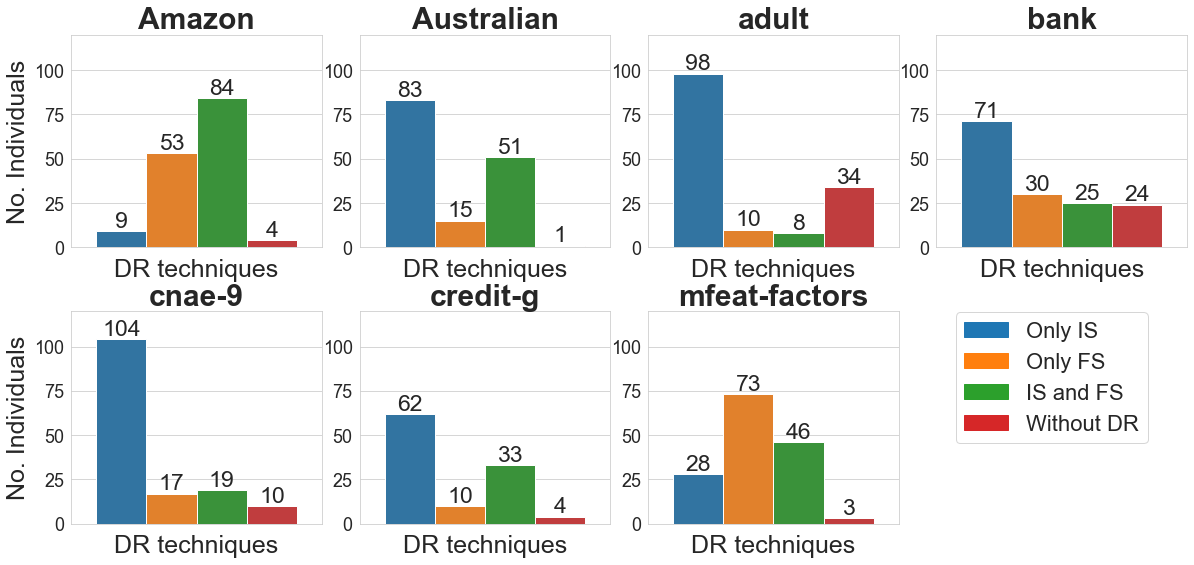

In [113]:
fig, axes = plt.subplots(nrows=2, ncols=int((1+len(datasets))/2), figsize=(20,9),sharey=False, sharex=False)
sns.set_style('whitegrid')
col = 0
row = 0
for dataset in datasets:
    ax = axes[row][col]
    df = pd.DataFrame(data_dr[dataset])[show_framework].to_frame()
    df.columns = [frameworks[framework] for framework in df.columns]
    df.index.name = 'DR applied'
    df_melted = df.reset_index().melt(id_vars='DR applied', var_name='edca', value_name='Number of Individuals')
    sns.barplot(
        x='edca', 
        y='Number of Individuals', 
        hue='DR applied', 
        data=df_melted, 
        # dodge=0.8, 
        ax=ax, 
        order=list(df.columns),
        palette=dr_palette)
    for p in ax.patches:
        value = p.get_height()
        if np.isnan(value) == False:
            value = int(value)
        ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=23)
    # remove xticks name
    ax.set_xticklabels('')
    # set yticks font size

    if col == 0:
        ax.set_ylabel('No. Individuals')
    else:
        ax.set_ylabel('')
    ax.legend().set_visible(False)
    ax.set_xlabel("DR techniques")
    ax.set_ylim(0, 120)
    if dataset == 'Amazon_employee_access':
        ax.set_title('Amazon')
    elif dataset == 'bank-marketing':
        ax.set_title('bank')
    else:
        ax.set_title(dataset)
    ax.tick_params(axis='both', labelsize=18)
    col += 1
    if col == int((1+len(datasets))/2):
        col = 0
        row += 1

if len(datasets) % 2 != 0:  
    fig.delaxes(axes[-1][-1])
handles = [plt.Rectangle((0, 0), 1, 1, color=dr_color_mapping[cat]) for cat in possible_dr]
labels = possible_dr

last_deleted_axes_position = axes[-1, -1].get_position()
inset_ax = fig.add_axes(last_deleted_axes_position)
inset_ax.axis('off')

inset_ax.legend(handles, labels, loc='upper left', fontsize=22)
# fig.legend(handles, labels, title='', ncol=len(handles), loc='lower center', bbox_to_anchor=(0.5, 0.01))
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.15)
plt.savefig(os.path.join(save_path, f'histogram_{show_framework}_dr_techniques.png'), bbox_inches='tight')
plt.savefig(os.path.join(save_path, f'histogram_{show_framework}_dr_techniques.eps'), bbox_inches='tight', format='eps')
plt.show()

In [77]:
list_dr = []
for dataset, values in data_dr.items():
    list_dr.append(pd.DataFrame(values)[show_framework].to_frame().sum(axis=1).to_frame(dataset))

In [78]:
dr_tech = pd.concat(list_dr, axis=1)

In [79]:
(dr_tech.sum(axis=1) / dr_tech.sum().sum()) * 100

Only IS       45.094153
Only FS       20.614470
IS and FS     26.362735
Without DR     7.928642
dtype: float64

In [80]:
dr = dr_tech.sum(axis=1).to_frame('Total').reset_index()
dr.columns = ['DR applied', 'Total']

In [81]:
def label_func(pct, allvalues):
    return f"{pct:.1f}%"

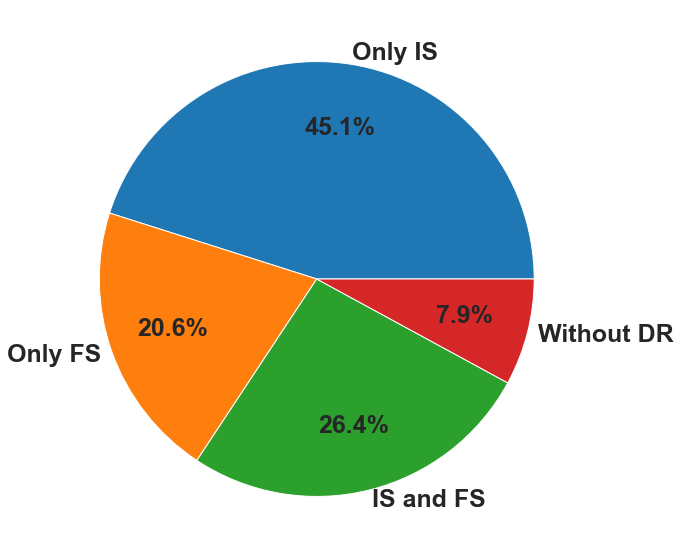

In [82]:
fig, ax = plt.subplots(figsize=(10, 10))
dr['Total'].plot(
    kind='pie', 
    labels=dr['DR applied'], 
    autopct='%1.1f%%', 
    ylabel='',
    labeldistance=1.05,
    pctdistance=0.7,
    textprops={
            'fontsize': 25,
            'fontweight': 'bold'},
    ax=ax)
plt.savefig(os.path.join(save_path, f'pie_{show_framework}_dr_techniques.png'), bbox_inches='tight')

## get best models

In [83]:
tpot_models = {}
for dataset in datasets:
    models = []
    for run in range(30):
        path = os.path.join('..', 'thesis-results', 'datasets-divided', 'tpot', dataset, f'run_{run}', 'results.json')
        with open(path) as file:
            results = json.load(file)
        for i in range(5):
            try:
                x = results['tpot_best_pipeline'][i]
                x = f'pipeline = Pipeline(steps={x})'
                exec(x)
                model_name = pipeline.steps[-1][1].__class__.__name__
                models.append(model_name)
            except:
                models.append(None)
                # print(pipeline)
    tpot_models[dataset] = models

In [84]:
flaml_models_map = {
    'lgbm' : 'LGBMClassifier',
    'xgboost' : 'XGBClassifier',
    'xgb_limitdepth' : 'XGBClassifier',
    'rf' : 'RandomForestClassifier',
    'lrl1' : 'LogisticRegression',
    'lrl2' : 'LogisticRegression',
    'kneighbor' : 'KNeighborsClassifier',
    'extra_tree' : 'ExtraTreesClassifier',
}

In [85]:
flaml_models = {}
for dataset in datasets:
    models = []
    for run in range(30):
        path = os.path.join('..', 'thesis-results', 'datasets-divided', 'flaml', dataset, f'run_{run}', 'results.json')
        with open(path) as file:
            results = json.load(file)
        for i in range(5):
            try:
                best_model = results['flaml_best_learner'][i]
                model_name = flaml_models_map[best_model]
                models.append(model_name)
            except:
                models.append(None)
    flaml_models[dataset] = models

In [86]:
edca_models = {}
for dataset in datasets:
    models =  data_models[dataset]['edca-1-0-0']
    edca_models[dataset] = models + [None] * (len(tpot_models[dataset]) - len(models))

In [87]:
possible_models = set()
for dataset in datasets:
    possible_models.update(set(tpot_models[dataset]))
    possible_models.update(set(flaml_models[dataset]))
    possible_models.update(set(edca_models[dataset]))

In [88]:
possible_models = list(possible_models)

In [89]:
possible_models = [m for m in possible_models if m is not None]
possible_models

['KNeighborsClassifier',
 'LogisticRegression',
 'XGBClassifier',
 'RandomForestClassifier',
 'LGBMClassifier',
 'ExtraTreesClassifier']

In [90]:
palette = sns.color_palette(n_colors=len(possible_models))

color_mapping = dict(zip(possible_models, palette))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


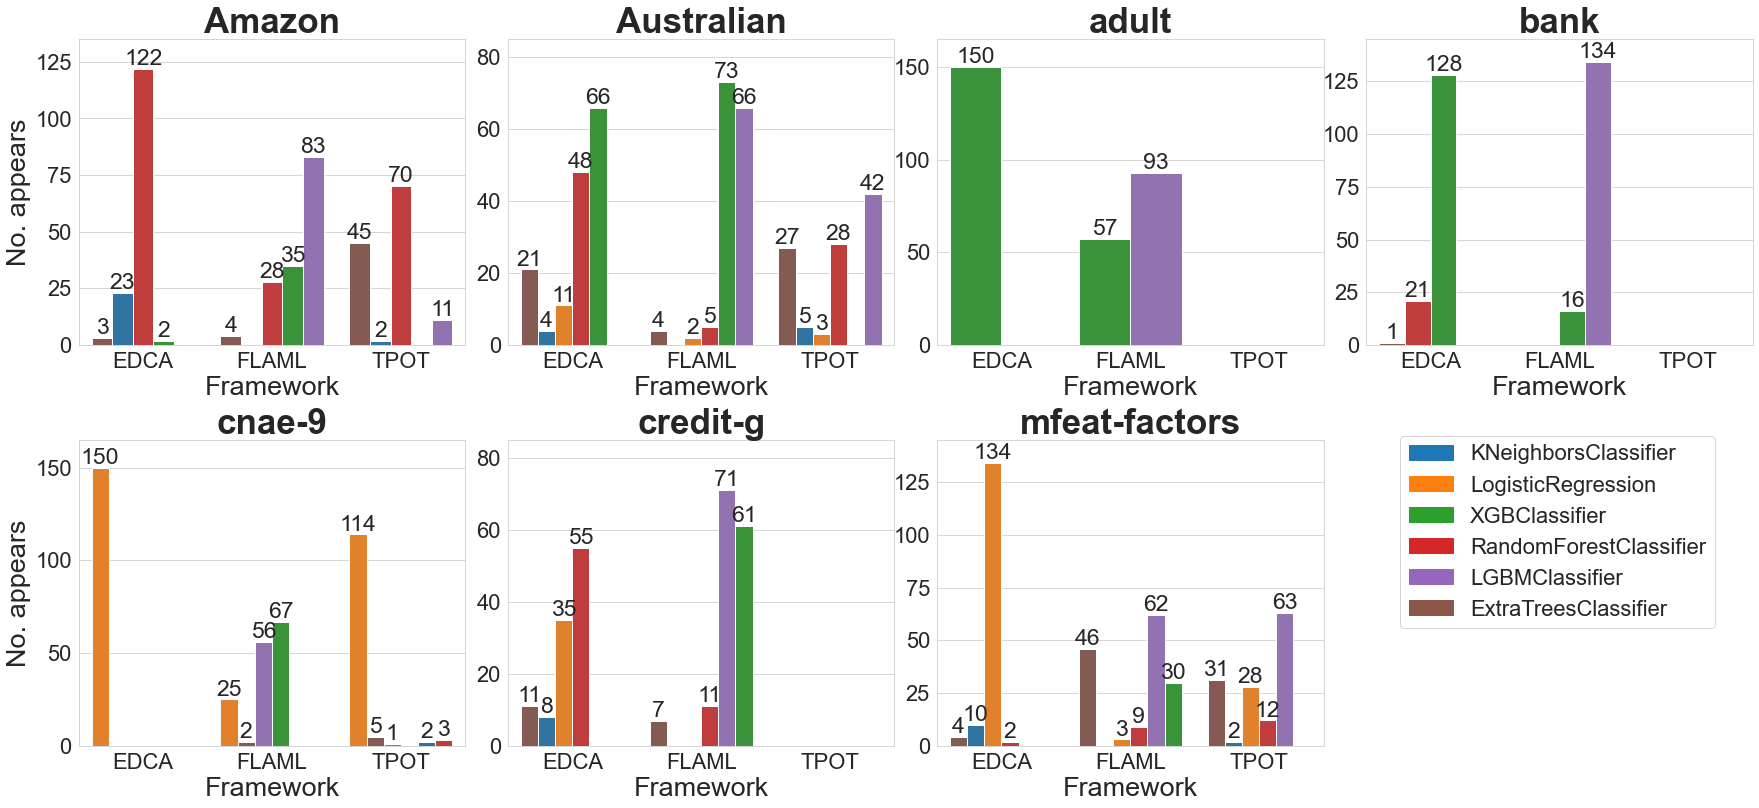

In [116]:
fig, axes = plt.subplots(nrows=2, ncols=int((1+len(datasets))/2), figsize=(30, 13), sharey=False)
sns.set_style('whitegrid')
col = 0
row = 0
for dataset in datasets:
    ax = axes[row][col]
    models = {
        'framework-EDCA' : edca_models[dataset],
        'framework-FLAML': flaml_models[dataset],
        'framework-TPOT' : tpot_models[dataset]
    }
    df = pd.DataFrame(models)
    df_melted = df.melt(var_name='Framework', value_name='Model')
    val = df_melted.groupby(['Framework', 'Model']).size().max()
    max_lim = int(np.floor(val/10) * 10)+15
    df_melted.Framework = df_melted.Framework.str.replace('framework-', '')
    categories_count = df_melted.groupby(['Framework', 'Model']).size().reset_index(name='Count')
    sns.barplot(
        x='Framework', 
        y='Count', 
        hue='Model', 
        data=categories_count, 
        order=['EDCA', 'FLAML', 'TPOT'], 
        ax=ax,
        palette=color_mapping)
    for p in ax.patches:
        value = p.get_height()
        if np.isnan(value) == False:
            value = int(value)
        ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=23)
    
    
    if col == 0:
        ax.set_ylabel('No. appears', fontdict=dict(size=27))
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', labelsize=22)
    ax.set_ylim(0, max_lim)
    ax.set_xlabel("Framework", fontdict=dict(size=27))
    if dataset == 'Amazon_employee_access':
        ax.set_title('Amazon', fontdict=dict(size=35, weight='bold'))
    elif dataset == 'bank-marketing':
        ax.set_title('bank', fontdict=dict(size=35, weight='bold'))
    else:
        ax.set_title(dataset, fontdict=dict(size=35, weight='bold'))
    ax.legend().set_visible(False)
    col += 1
    if col == int((1+len(datasets))/2):
        col = 0
        row += 1

fig.delaxes(axes[-1, -1])
last_deleted_axes_position = axes[-1, -1].get_position()
inset_ax = fig.add_axes(last_deleted_axes_position)
inset_ax.axis('off')
handles = [plt.Rectangle((0, 0), 1, 1, color=color_mapping[cat]) for cat in possible_models]
labels = possible_models

inset_ax.legend(handles, labels, loc='upper left', fontsize=22)
# fig.legend(handles, labels, title='', ncol=1, loc='lower right', fontsize=22)
# place legend on the location of the deleted subplot (the last one)
# fig.tight_layout()

plt.subplots_adjust(hspace=0.31)
plt.subplots_adjust(wspace=0.11)
plt.savefig(os.path.join(save_path, f'histogram_final_models_frameworks.png'), bbox_inches='tight')
plt.savefig(os.path.join(save_path, f'histogram_final_models_frameworks.eps'), bbox_inches='tight', format='eps')
plt.show()